# Music Valence

## Introduction

## Initialization

### Install Libraries

In [1]:
import sys
print(sys.version)

3.9.15 (main, Nov 24 2022, 14:39:17) [MSC v.1916 64 bit (AMD64)]


In [2]:
# !pip install librosa
# !pip install mir_eval
# !pip install glob

### Load Libraries

Loading Libraries, not all of them are needed at this point but they will be cleaned up once the project has been finished. 

In [3]:
from IPython.display import clear_output
import pandas as pd

# Enable plots in the notebook
%matplotlib inline
import matplotlib.pyplot as plt

# Seaborn to make the plots prettier
# import seaborn as sns
# sns.set(style='ticks')

# Import Audio playback widget
from IPython.display import Audio
import os

from glob import glob

# Useful libraries
import numpy as np
from tqdm import tqdm
import scipy

import mir_eval
from PIL import Image

import plotly.express as px
import plotly.graph_objects as go

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:
import librosa
import librosa.display

C:\Users\John\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


### Load Data

In [5]:
df = pd.read_csv('DEAM_Annotations/annotations/annotations averaged per song/song_level/static_annotations_averaged_songs_1_2000.csv')

### Audio info

#### Function for Checking The Dataframe

In [6]:
def data_check(df):
    print('\033[94m''dataframe shape:''\033[90m')
    print(df.shape)
    print()
    print('\033[94m''df column names:''\033[90m')
    print(df.columns.tolist())
    print()
    print('\033[94m''df info:''\033[90m')
    print(df.info())
    print()
    print('\033[94m''Percentage of missing values:''\033[90m')
    for col in df.columns.tolist():
        missing_val = df[col].isna().sum() / df.shape[0] * 100
# We only want to display columns with missing data here. 
        if missing_val > 0:
            print(col, 'NaN%:', missing_val)
    print()
    print('\033[94m''Number of duplicates:''\033[90m')
    print(df.duplicated().sum())
    print()
    print('\033[94m''print a few columns:''\033[90m')
    with pd.option_context('display.max_rows', 10,
                       'display.max_columns', None,
                       'display.width', 1000,
                       'display.precision', 3,
                       'display.colheader_justify', 'center'):
        print(display(df.sample(10)))


#### Checking the Dataframe

In [7]:
data_check(df)

dataframe shape:
(1744, 5)

df column names:
['song_id', ' valence_mean', ' valence_std', ' arousal_mean', ' arousal_std']

df info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1744 entries, 0 to 1743
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   song_id        1744 non-null   int64  
 1    valence_mean  1744 non-null   float64
 2    valence_std   1744 non-null   float64
 3    arousal_mean  1744 non-null   float64
 4    arousal_std   1744 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 68.2 KB
None

Percentage of missing values:

Number of duplicates:
0

print a few columns:


song_id   valence_mean   valence_std   arousal_mean   arousal_std
884    1141         4.5           1.36           3.6           1.28    
94      120         3.8           1.60           5.0           1.61    
1135   1392         6.2           1.72           6.7           1.68    
797    1054         3.7           2.49           6.3           2.49    
1164   1421         4.2           1.89           3.2           1.60    
1041   1298         6.9           0.94           5.6           1.36    
1509   1766         3.7           1.19           3.0           1.10    
1019   1276         4.8           1.08           5.5           0.81    
1500   1757         5.0           0.77           3.1           0.83    
933    1190         3.5           1.75           2.2           0.87

None


#### Fixing Columns and Enriching

In [8]:
df.rename(columns={' valence_mean':'valence_mean',
          ' valence_std':'valence_std',
          ' arousal_mean':'arousal_mean',
          ' arousal_std':'arousal_std'}, inplace=True)

In [9]:
df['file'] = df.song_id.astype(str) + '.mp3'
df.sample()


song_id  valence_mean  valence_std  arousal_mean  arousal_std     file
329      387           6.2         2.27           6.2         2.52  387.mp3

###  Test Audio

##### Create Audio Path

#### Mel Spectrogram

In [10]:
audio_data_path = 'DEAM_audio/MEMD_audio/'

##### Create Filter Banks

In [11]:
filter_banks = librosa.filters.mel(n_fft=2048, sr=22050, n_mels=40)

In [12]:
filter_banks.shape

(40, 1025)

##### Load a single file to check things work

##### Loading the Test File

In [13]:
y, sr = librosa.load('DEAM_audio/MEMD_audio/4.mp3',offset=0,  duration=44)
display(y.shape)
display(sr)

C:\Users\John\anaconda3\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


(970200,)

22050

##### Create Test Mel Spectrogram

<function matplotlib.pyplot.show(close=None, block=None)>

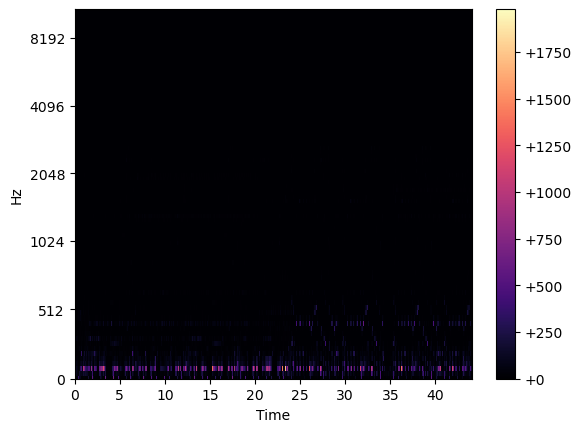

In [14]:
ps = librosa.feature.melspectrogram(y, sr=sr, n_fft=2048, hop_length=512, n_mels=90, fmax=11025)
librosa.display.specshow(ps, x_axis='time', y_axis='mel', sr=sr)
plt.colorbar(format="%+2.f")
plt.show

##### Setting the specshow size

Setting the figsize was important for this step as it allowed me to create a larger visual image in order to be able to inspect the details. This was important as it allowed me to inspect it each time I adjusted the parameters for the Mel Spectrogram. What I was looking for here was the image that gave clear separation of the bands while not having huge file sizes, the graphics card for training was limited to only 8GB which limited the image sizes that I could process. 

In [15]:
plt.rcParams["figure.figsize"] = [20, 9]

##### Displaying the Mel Spectrogram

<function matplotlib.pyplot.show(close=None, block=None)>

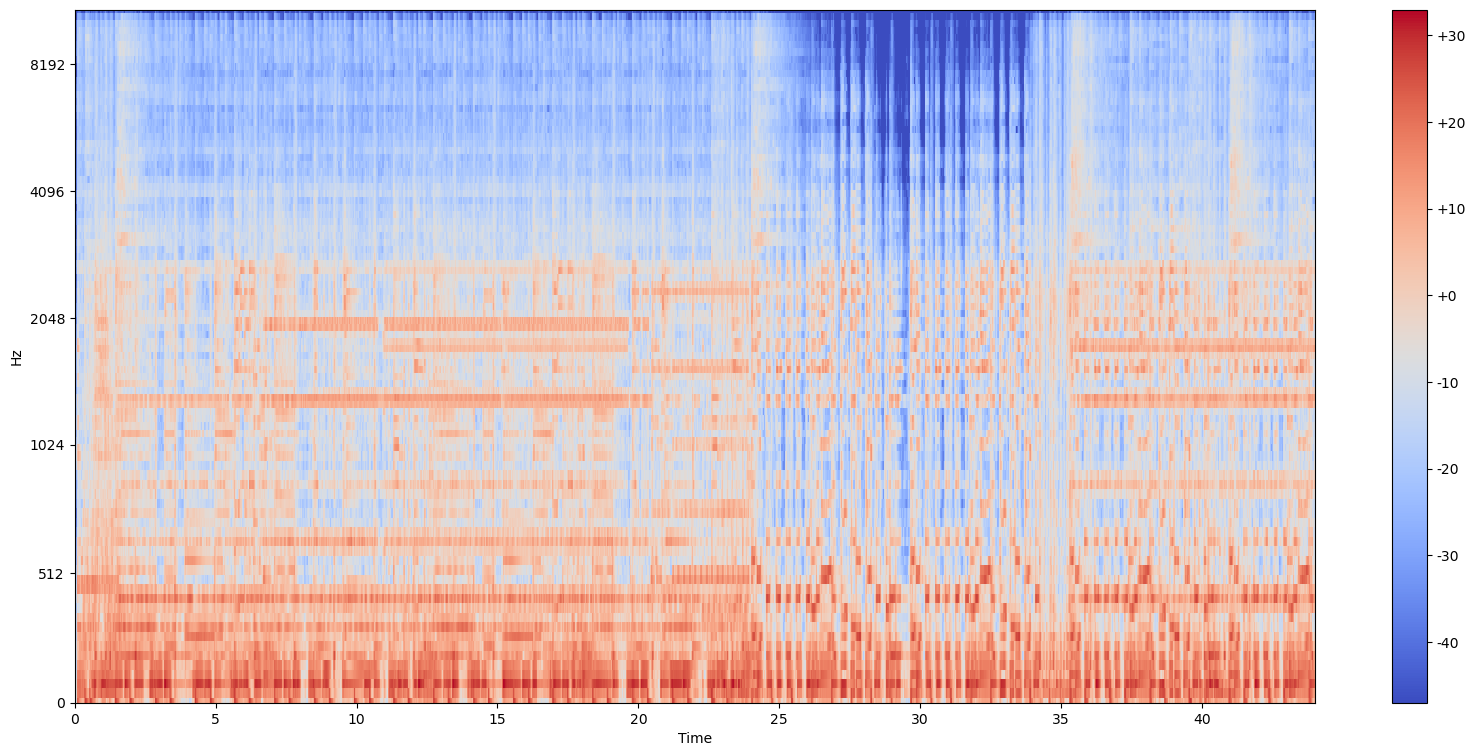

In [16]:
ps_log_scale = librosa.power_to_db(ps)
librosa.display.specshow(ps_log_scale, x_axis='time', y_axis='mel', sr=sr, fmax=11025)
plt.colorbar(format="%+2.f")
plt.show

In [17]:
ps_log_scale

array([[-47.034878 , -47.034878 ,  -6.7991037, ...,   7.5520544,
          4.0292864,   7.2775264],
       [-47.034878 , -47.034878 ,  -6.067564 , ...,  15.21925  ,
         12.929613 ,  11.634984 ],
       [-47.034878 , -47.034878 ,  -6.0282545, ...,  25.036797 ,
         24.51836  ,  21.950191 ],
       ...,
       [-47.034878 , -47.034878 , -38.58438  , ..., -23.671057 ,
        -23.111492 , -21.703789 ],
       [-47.034878 , -47.034878 , -47.034878 , ..., -33.56683  ,
        -34.261597 , -31.701923 ],
       [-47.034878 , -47.034878 , -47.034878 , ..., -42.70179  ,
        -45.4681   , -41.349712 ]], dtype=float32)

#### MFCC

##### Create MFCC

In [18]:
# signal, sr = librosa.load('DEAM_audio/MEMD_audio/4.mp3',offset=0,  duration=10)
# signal.shape

In [19]:
# mfccs = librosa.feature.mfcc(signal, n_mfcc=90, sr=sr)

In [20]:
# mfccs.shape

In [21]:
# plt.figure(figsize=(5,3))
# librosa.display.specshow(mfccs, 
#                          x_axis='time',
#                          sr=sr)
# plt.colorbar(format="%+2f")
# plt.show()

In [22]:
# delta_mfccs = librosa.feature.delta(mfccs)
# delta2_mfccs = librosa.feature.delta(mfccs, order=2)

In [23]:
# delta_mfccs.shape

In [24]:
# plt.figure(figsize=(12,5))
# librosa.display.specshow(delta_mfccs, 
#                          x_axis='time',
#                          sr=sr)
# plt.colorbar(format="%+2f")
# plt.show()

In [25]:
# plt.figure(figsize=(12,5))
# librosa.display.specshow(delta2_mfccs, 
#                          x_axis='time',
#                          sr=sr)
# plt.colorbar(format="%+2f")
# plt.show()

In [26]:
# comprehensive_mfccs = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))

In [27]:
# comprehensive_mfccs.shape

In [28]:
# plt.figure(figsize=(12,5))
# librosa.display.specshow(comprehensive_mfccs, 
#                          x_axis='time',
#                          sr=sr)
# plt.colorbar(format="%+2f")
# plt.show()

In [29]:
# segment_length = 10
# samples_per_segment = segment_length * sr
# extracted_features = []
# extracted_valence = []
# for index_n, row in tqdm(df.iterrows()):
# #     if index_n >= 40:
# #         break
#     file_name = os.path.join(os.path.abspath(audio_data_path), str(row['file']))
#     valence_val = row["valence_mean"]
    
#     y, sr = librosa.load(file_name, duration=40) # max duration is 44
#     segments = librosa.util.frame(y, frame_length=samples_per_segment, hop_length=samples_per_segment).T
#     for i, segment in enumerate(segments):
#         mfccs = librosa.feature.mfcc(segment, n_mfcc=90, sr=sr)
# #         delta_mfccs = librosa.feature.delta(mfccs)
# #         delta2_mfccs = librosa.feature.delta(mfccs, order=2)
# #         comprehensive_mfccs = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
#         extracted_features.append(mfccs)
#         extracted_valence.append(valence_val)

### Extracting All Audio

#### Create function for extracting MelSpectrograms

In [30]:
# def feature_extract(file):
#     y, sr = librosa.load(file, duration=44) # max duration is 44
#     ms = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=120)
#     ms_log = np.array(librosa.power_to_db(ms))
#     return ms_log

#### Create Mel Spectrograms for all files

In [31]:
# extracted_features = []
# extracted_valence = []
# for index_n, row in tqdm(df.iterrows()):
# #     if index_n > 10:
# #         break
#     file_name = os.path.join(os.path.abspath(audio_data_path), str(row['file']))
#     valence_val = row["valence_mean"]
    
#     y, sr = librosa.load(file_name, duration=40) # max duration is 44
#     segment_length = 10
#     samples_per_segment = segment_length * sr
#     segments = librosa.util.frame(y, frame_length=samples_per_segment, hop_length=samples_per_segment).T
#     for i, segment in enumerate(segments):
#         mel_spectrogram = librosa.feature.melspectrogram(segment, sr=sr, n_fft=1024, hop_length=256, n_mels=90)
#         mel_spectrogram_log = np.array(librosa.power_to_db(mel_spectrogram))
        
#         extracted_features.append(mel_spectrogram_log)
#         extracted_valence.append(valence_val)

In [32]:
# extracted_features = []
# extracted_valence = []
# for index_n, row in tqdm(df.iterrows()):

#     file_name = os.path.join(os.path.abspath(audio_data_path), str(row['file']))
#     valence_val = row["valence_mean"]
#     data = feature_extract(file_name)
#     extracted_features.append(data)
#     extracted_valence.append(valence_val)

#### Saving and Loading Extracted Audios

We have several saved files here with different extracted Mel Spectrograms

In [33]:
# x = np.array(extracted_features).astype(np.float32)
# y = np.array(extracted_valence).astype(np.float32)

In [34]:
# np.save("features_10-90MFCC.npy", x)
# np.save("valence_10-90MFCC.npy", y)
# extracted_features = np.load("features_10-90MFCC.npy") # audio 10s segments, n_mfcc=90
# extracted_valence = np.load("valence_10-90MFCC.npy")
# extracted_features = np.load("features_10-45MFCC.npy") # audio 10s segments, n_mfcc=45, delta & delta2
# extracted_valence = np.load("valence_10-45MFCC.npy")
extracted_features = np.load("features_10_1024.npy") # audio 5s segments, n_fft=1024, hop=256, 90 mels
extracted_valence = np.load("valence_10_1024.npy")
# extracted_features = np.load("features_split5s.npy") # Audio split into 5 second segments
# extracted_valence = np.load("valence_split5s.npy")
# extracted_features = np.load("features_split.npy") # Audio in 10 second segments
# extracted_valence = np.load("valence_split.npy")
# extracted_features = np.load("features.npy") # 30 second spectrogram
# extracted_valence = np.load("valence.npy")
# extracted_features = np.load("features_HD.npy") # much higher number of mels, 30 seconds 
# extracted_valence = np.load("valence_HD.npy")

#### Graph a couple to make sure they work. 

In [35]:
# plt.rcParams["figure.figsize"] = [3, 2]
# for x in range(100):
#     print(extracted_valence[x])
#     librosa.display.specshow(extracted_features[x], x_axis='time', y_axis='mel', sr=sr)
#     plt.show()
#     print('----------------------------------------------------')

## Checking and Fixing Data

Preparing the features and target. The type had to be set to float32 so that they could be converted to tensors in the CNN.

In [36]:
feature_array = np.array(extracted_features).astype(np.float32)
target_array = np.array(extracted_valence).astype(np.float32)

del extracted_features, extracted_valence

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(feature_array, target_array, test_size=0.4, random_state=42)
# because this is split after we made all the other code we will use validation set for testing. 
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

Get the shape of the Mel Spectrograms for the model. 

In [37]:
feature_array.shape

(13952, 90, 431)

We need to find the max value to scale buy for model training. This strictly was not required, but it did return slightly more accurate models. 

In [38]:
feature_array[8]

array([[-57.769184 , -57.769184 , -57.769184 , ...,   9.489743 ,
          5.780718 ,  11.6051655],
       [-57.769184 , -57.769184 , -57.769184 , ...,  10.891903 ,
          6.838796 ,  12.218981 ],
       [-57.769184 , -57.769184 , -57.769184 , ...,   8.105873 ,
          4.6671476,   8.526238 ],
       ...,
       [-57.769184 , -57.769184 , -57.769184 , ..., -57.769184 ,
        -57.769184 , -53.17629  ],
       [-57.769184 , -57.769184 , -57.769184 , ..., -57.769184 ,
        -57.769184 , -57.769184 ],
       [-57.769184 , -57.769184 , -57.769184 , ..., -57.769184 ,
        -57.769184 , -57.769184 ]], dtype=float32)

In [39]:
# xmax = np.max(feature_array)
# xmin = np.min(feature_array)
# print(xmin)
# print(xmax)        

Find the value to scale for in the model. This can be different based on the number of Mels and the input Dataset. 

In [40]:
# if abs(xmin) > abs(xmax):
#     feature_scalar = abs(xmin)
# #     differ = abs(xmax - 1) / 4
# #     scalar = abs(xmin) - differ
# else:
#     feature_scalar = abs(xmax)
# #     differ = abs(xmin - 1) / 4
# #     scalar = abs(xmax) - differ
# # display(differ)
feature_scalar = 100

### Scale the mel Spectrogram output

In [41]:
# x_train = x_train / feature_scalar
# x_test = x_test / feature_scalar
# x_valid = x_valid / feature_scalar

mean = np.mean(x_train, axis=0)
std = np.std(x_train, axis=0)
x_train = np.divide(np.subtract(x_train, mean), std)
x_test = np.divide(np.subtract(x_test, mean), std)
x_valid = np.divide(np.subtract(x_valid, mean), std)

In [42]:
xmax_a = np.max(x_train)
xmin_a = np.min(x_train)
print(xmin_a)
print(xmax_a) 

-7.366974
5.678739


In [43]:
del feature_array, target_array

## Create Model

### Load modules

In [44]:
from keras import backend as K
import tensorflow as tf
import torch
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error

### Create Model

#### Test Tensorflow and Torch

We run these tests to make sure the GPU is configured correctly.

In [45]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
tf.config.experimental.set_memory_growth(gpus[0], True)
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.LogicalDeviceConfiguration(memory_limit=5632)])

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [46]:
# print(tf.__version__)
# 

In [47]:
# tf.test.is_built_with_cuda()

In [48]:
# tf.test.is_gpu_available()

In [49]:
# tf.config.list_physical_devices("GPU")

In [50]:
# tf.test.gpu_device_name()

#### Checkpoint and early stopping 

We want early stopping so we don't have to worry about the number of epochs, and we save the best model so that we can use that output for our analysis later. 

In [51]:
early_stop = EarlyStopping(monitor='val_loss', patience=20)
checkpoint = ModelCheckpoint('saved_model/best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

#### The model

In [52]:
model_dropout = 0.06
regular_val = 0.0005

In [53]:
%%time
from tensorflow.random import set_seed
optimizer = Adam(learning_rate=0.0005) 
with tf.device('/gpu:0'):
    set_seed(64)
    # Set up the model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=(90, 431, 1)))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Dropout(model_dropout))
        
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Dropout(model_dropout))

    model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Dropout(model_dropout))

    model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Dropout(model_dropout))

    model.add(tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Dropout(model_dropout))   
    
    model.add(tf.keras.layers.Conv2D(2048, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Dropout(model_dropout))       
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=512, activation='relu'))
    model.add(tf.keras.layers.Dense(units=1,
                                    activation='linear'
                                   ))

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

    # Fit the model
    model.fit(x_train, y_train, epochs=200, batch_size=64, validation_data=(x_test, y_test), callbacks=[early_stop, checkpoint])
    

Epoch 1/200
131/131 [==============================] - 63s 388ms/step - loss: 4.4007 - root_mean_squared_error: 2.0978 - val_loss: 1.2437 - val_root_mean_squared_error: 1.1152
Epoch 2/200
131/131 [==============================] - 42s 322ms/step - loss: 0.8745 - root_mean_squared_error: 0.9351 - val_loss: 1.6940 - val_root_mean_squared_error: 1.3015
Epoch 3/200
131/131 [==============================] - 38s 292ms/step - loss: 0.8335 - root_mean_squared_error: 0.9130 - val_loss: 0.8059 - val_root_mean_squared_error: 0.8977
Epoch 4/200
131/131 [==============================] - 38s 289ms/step - loss: 0.7850 - root_mean_squared_error: 0.8860 - val_loss: 0.7861 - val_root_mean_squared_error: 0.8866
Epoch 5/200
131/131 [==============================] - 37s 284ms/step - loss: 0.7613 - root_mean_squared_error: 0.8725 - val_loss: 0.9840 - val_root_mean_squared_error: 0.9920
Epoch 6/200
131/131 [==============================] - 37s 284ms/step - loss: 0.7222 - root_mean_squared_error: 0.8498 -

131/131 [==============================] - 35s 265ms/step - loss: 0.0348 - root_mean_squared_error: 0.1867 - val_loss: 0.3564 - val_root_mean_squared_error: 0.5970
Epoch 94/200
131/131 [==============================] - 35s 266ms/step - loss: 0.0298 - root_mean_squared_error: 0.1727 - val_loss: 0.3600 - val_root_mean_squared_error: 0.6000
Epoch 95/200
131/131 [==============================] - 34s 263ms/step - loss: 0.0312 - root_mean_squared_error: 0.1767 - val_loss: 0.3616 - val_root_mean_squared_error: 0.6013
Epoch 96/200
131/131 [==============================] - 35s 265ms/step - loss: 0.0304 - root_mean_squared_error: 0.1744 - val_loss: 0.3613 - val_root_mean_squared_error: 0.6011
Epoch 97/200
131/131 [==============================] - 35s 269ms/step - loss: 0.0324 - root_mean_squared_error: 0.1799 - val_loss: 0.3540 - val_root_mean_squared_error: 0.5950
Epoch 98/200
131/131 [==============================] - 35s 265ms/step - loss: 0.0287 - root_mean_squared_error: 0.1695 - val_lo

Epoch 70/70
44/44 [==============================] - 4s 91ms/step - loss: 0.0232 - mae: 0.1218 - val_loss: 0.4843 - val_mae: 0.5462

#### Load the Best model

In [54]:
model = tf.keras.models.load_model('saved_model/best_model.h5')

#### Save the model

We want to save the best model to something more permanent. 

In [55]:
# model.save('saved_model/Model_MFCC_5_90_1024_MSE32688895.h5')

#### Load a previously saved model.

In [56]:
# model = tf.keras.models.load_model('saved_model/Model_MFCC_5_90_1024_MSE.h5')

#### Get Predictions 

In [57]:
y_pred = model.predict(x_test)

88/88 [==============================] - 4s 34ms/step


In [58]:
y_pred_valid = model.predict(x_valid)

88/88 [==============================] - 3s 34ms/step


#### Sanity Check

MSE of the test set. 

In [59]:
mean_squared_error(y_test, y_pred)

0.3358107

In [60]:
mean_squared_error(y_valid, y_pred_valid)

0.35091874

Create a np.array with the mean values of the expected outcomes. 

In [61]:
y_med = np.full(len(y_test), np.mean(y_test))

find the MSE when using the mean values. 

In [62]:
mse = mean_squared_error(y_test, y_med)
print(mse)

1.3679017


We can see here that the MSE is much better in our predictions than when we just used the mean values. This tells us that our model is useful. 

#### Graphing Model Vs Expected

This is a very important graph, it tells us how our model predicts the values vs the expected values, and using the trend line we can see how it compares to what a perfect model would predict. 

In [63]:
y_test = y_test.reshape(-1)
y_pred = y_pred.reshape(-1)
x_vals = np.linspace(np.min([y_test, y_pred]), np.max([y_test, y_pred]), 100)
coef = np.polyfit(y_test, y_pred, 1)
poly1d_fn = np.poly1d(coef)
coef_test = np.polyfit(y_test, y_test, 1)

scatter1 = go.Scatter(x=y_test, y=y_pred, mode='markers', name='y_test vs y_pred')
scatter2 = go.Scatter(x=y_test, y=y_med, mode='lines', name='y_test vs y_med')
scatter3 = go.Scatter(x=y_test, y=y_test, mode='lines', name='expected y = {:.2f}x + {:.2f}'.format(coef_test[0],coef_test[1]))
trend_line = go.Scatter(x=x_vals, y=poly1d_fn(x_vals), mode='lines', name='y = {:.2f}x + {:.2f}'.format(coef[0],coef[1]))

layout = go.Layout(xaxis = dict(range = [0, 10]),
                   yaxis = dict(range = [0, 10]),
                   width=1200,
                   height=1000,
                   xaxis_title = "real",
                   yaxis_title = "predicted")

fig = go.Figure(data=[scatter1, scatter2, scatter3, trend_line], layout=layout)
fig.show()

## Conclusions 

This model is doing what it is expected to effectively, however there are some improvements that can still be made. Using a better GPU Cross validation would be an option, we could also use the second by second annotations to get a more accurate model. It would take significantly more time to prepare the data for that, and significantly more compute time. If the accuracy of this model is the end goal it would also be important to have a music professional checking the outputs on predictions for new songs and reintegrating that into the model to further train it. 

## Test Set

In [64]:
df_test = pd.read_csv('DEAM_Annotations/annotations/annotations averaged per song/song_level/static_annotations_averaged_songs_2000_2058.csv')

In [65]:
data_check(df_test)

dataframe shape:
(58, 13)

df column names:
['song_id', ' valence_mean', ' valence_std', ' valence_ max_mean', ' valence_max_std', ' valence_min_mean', ' valence_min_std', ' arousal_mean', ' arousal_std', ' arousal_max_mean', ' arousal_max_std', ' arousal_min_mean', ' arousal_min_std']

df info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   song_id             58 non-null     int64  
 1    valence_mean       58 non-null     float64
 2    valence_std        58 non-null     float64
 3    valence_ max_mean  58 non-null     float64
 4    valence_max_std    58 non-null     float64
 5    valence_min_mean   58 non-null     float64
 6    valence_min_std    58 non-null     float64
 7    arousal_mean       58 non-null     float64
 8    arousal_std        58 non-null     float64
 9    arousal_max_mean   58 non-null     float64
 10   arousa

song_id   valence_mean   valence_std   valence_ max_mean   valence_max_std   valence_min_mean   valence_min_std   arousal_mean   arousal_std   arousal_max_mean   arousal_max_std   arousal_min_mean   arousal_min_std
13   2014        3.00           0.63             4.40               1.02              1.80               0.40            6.60           0.80            8.40               0.49              4.20               0.98      
53   2054        5.40           1.20             6.00               1.10              4.40               1.36            3.60           1.36            4.20               1.33              2.40               0.80      
28   2029        4.17           1.07             5.50               1.38              3.33               0.94            4.00           1.29            5.17               1.46              3.33               1.60      
11   2012        3.17           0.69             4.50               0.50              1.83               0.69            5.17           1.67            7.33               1.70              2.67               1.49      
15   2016        7.20           0.40             8.00               0.63              6.40               0.49            5.60           2.24            6.40               2.42              4.40               1.85      
17   2018        6.50           0.50             7.33               0.47              5.83               1.07            6.33           0.75            7.50               0.96              5.67               0.94      
52   2053        3.80           0.40             4.40               0.49              3.20               0.75            3.80           1.83            5.20               1.60              2.60               1.20      
6    2007        3.40           0.49             5.00               1.10              2.40               0.80            4.40           1.36            6.20               1.47              2.40               1.02      
27   2028        3.40           0.49             5.20               1.47              2.40               0.49            6.20           1.17            8.20               1.17              3.40               1.50      
21   2022        3.80           0.75             4.60               1.20              2.80               0.75            4.40           1.36            5.60               1.02              2.60               1.20

None


In [66]:
df_test = df_test.rename(columns={' valence_mean':'valence_mean'})

In [67]:
df_test = df_test.drop([' valence_std', ' valence_ max_mean', ' valence_max_std', ' valence_min_mean', ' valence_min_std', ' arousal_mean', ' arousal_std', ' arousal_max_mean', ' arousal_max_std', ' arousal_min_mean', ' arousal_min_std'], axis=1)

In [68]:
df_test['file'] = df_test.song_id.astype(str) + '.mp3'
df_test.sample()

song_id  valence_mean      file
24     2025           6.0  2025.mp3

In [69]:
extracted_features_test = []
extracted_valence_test = []
for index_n, row in tqdm(df_test.iterrows()):
#     if index_n == 1:
#         break
    file_name = os.path.join(os.path.abspath(audio_data_path), str(row['file']))
    valence_val = row["valence_mean"]
    
    y, sr = librosa.load(file_name, offset=10, duration=40) # max duration is 44
    segment_length = 5
    samples_per_segment = segment_length * sr
    segments = librosa.util.frame(y, frame_length=samples_per_segment, hop_length=samples_per_segment).T
    for i, segment in enumerate(segments):
        mel_spectrogram = librosa.feature.melspectrogram(segment, sr=sr, n_fft=1024, hop_length=256, n_mels=90)
        mel_spectrogram_log = np.array(librosa.power_to_db(mel_spectrogram))
        
        extracted_features_test.append(mel_spectrogram_log)
        extracted_valence_test.append(valence_val)

0it [00:00, ?it/s]C:\Users\John\anaconda3\lib\site-packages\librosa\core\audio.py:165: UserWarning:

PySoundFile failed. Trying audioread instead.

58it [00:52,  1.11it/s]


In [70]:
# segment_length = 10
# samples_per_segment = segment_length * sr
# extracted_features_test = []
# extracted_valence_test = []
# for index_n, row in tqdm(df_test.iterrows()):
# #     if index_n >= 40:
# #         break
#     file_name = os.path.join(os.path.abspath(audio_data_path), str(row['file']))
#     valence_val = row["valence_mean"]
    
#     y, sr = librosa.load(file_name, duration=40) # max duration is 44
#     segments = librosa.util.frame(y, frame_length=samples_per_segment, hop_length=samples_per_segment).T
#     for i, segment in enumerate(segments):
#         mfccs = librosa.feature.mfcc(segment, n_mfcc=90, sr=sr)
# #         delta_mfccs = librosa.feature.delta(mfccs)
# #         delta2_mfccs = librosa.feature.delta(mfccs, order=2)
# #         comprehensive_mfccs = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
#         extracted_features_test.append(mfccs)
#         extracted_valence_test.append(valence_val)

3.2


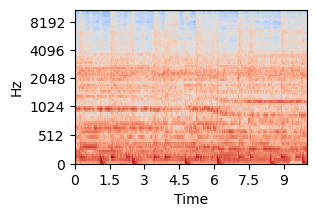

--------------------------------------------
3.2


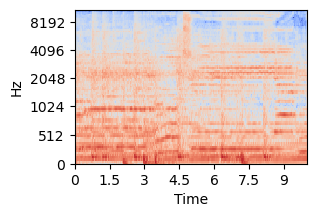

--------------------------------------------
3.2


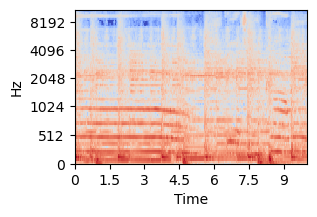

--------------------------------------------
3.2


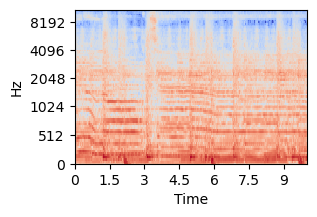

--------------------------------------------
3.2


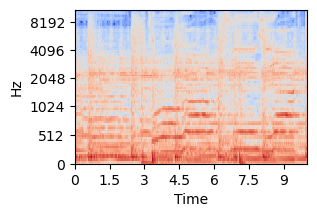

--------------------------------------------
3.2


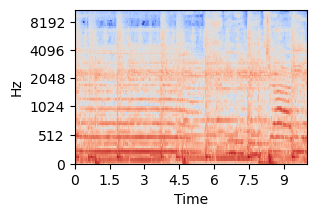

--------------------------------------------
3.2


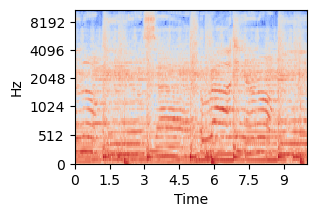

--------------------------------------------
3.2


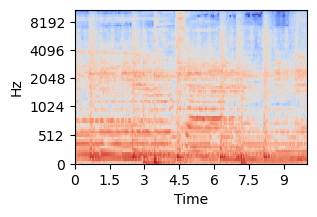

--------------------------------------------
6.4


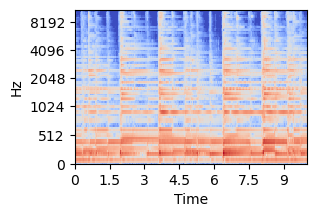

--------------------------------------------
6.4


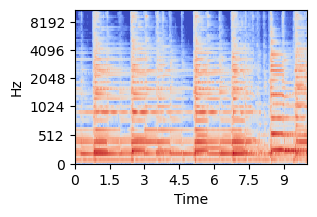

--------------------------------------------
6.4


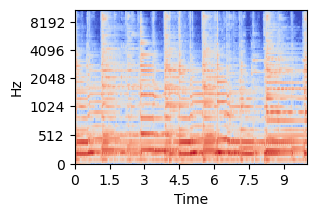

--------------------------------------------
6.4


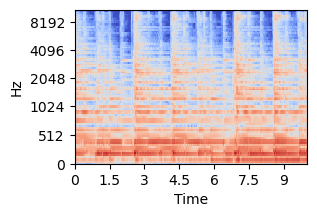

--------------------------------------------
6.4


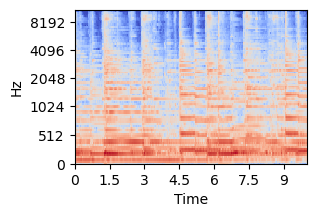

--------------------------------------------
6.4


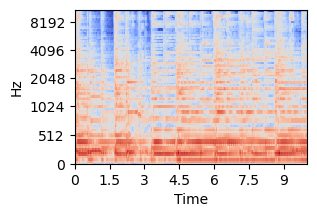

--------------------------------------------
6.4


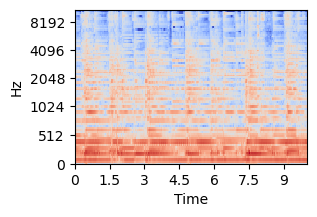

--------------------------------------------
6.4


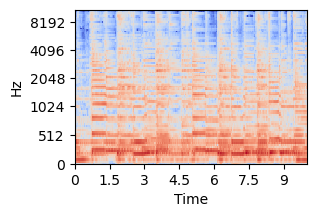

--------------------------------------------
5.4


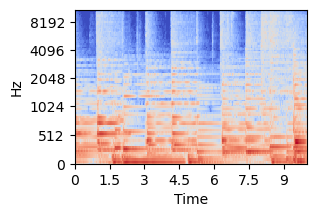

--------------------------------------------
5.4


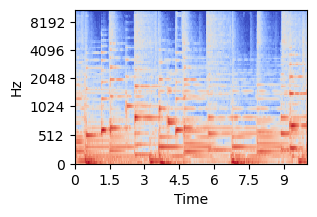

--------------------------------------------
5.4


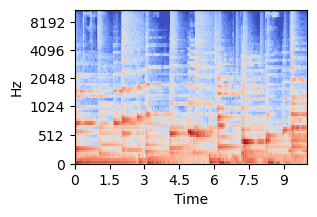

--------------------------------------------
5.4


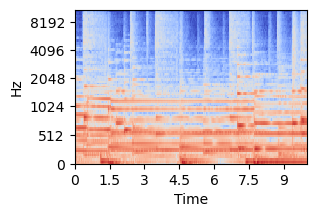

--------------------------------------------


In [71]:
plt.rcParams["figure.figsize"] = [3, 2]
for x in range(20):
    print(extracted_valence_test[x])
    librosa.display.specshow(extracted_features_test[x], x_axis='time', y_axis='mel', sr=sr)
    plt.show()
    print('--------------------------------------------')

In [72]:
extracted_features_test[0].shape

(90, 431)

In [73]:
# extracted_features_test = extracted_features_test / feature_scalar

In [74]:
extracted_features_test = np.array(extracted_features_test).astype(np.float32)

In [75]:
target_pred = model.predict(extracted_features_test)

15/15 [==============================] - 1s 71ms/step


In [76]:
extracted_valence_test = np.array(extracted_valence_test)

In [77]:
extracted_valence_test = extracted_valence_test.reshape(-1)
target_pred = target_pred.reshape(-1)

In [78]:
mean_squared_error(target_pred, extracted_valence_test)

2.8258535364438164

In [79]:
coef_test_set = np.polyfit(extracted_valence_test, target_pred, 1)
x_vals = np.linspace(np.min([extracted_valence_test, target_pred]), np.max([extracted_valence_test, target_pred]), 100)
scatter = go.Scatter(x=extracted_valence_test, y=target_pred, mode='markers')
trend_line = go.Scatter(x=x_vals, y=poly1d_fn(x_vals), mode='lines', name='y = {:.2f}x + {:.2f}'.format(coef_test_set[0],coef_test_set[1]))

layout = go.Layout(xaxis = dict(range = [0, 10]),
                   yaxis = dict(range = [0, 10]),
                   width=1200,
                   height=1000,
                   xaxis_title = "real",
                   yaxis_title = "predicted")

fig = go.Figure(data=[scatter, trend_line], layout=layout)

fig.show()

There is a lot to this, the test set here is from real world songs. It is from the additional songs in the DEAM dataset. This indicates that the problem is not the Spotify data but how the analysis of the songs are being done. 

There are a couple of things that could be leading to this result
 - Audio compression
 - Mel-Spectrogram Quality
 - Mel-Spectrograms not being suited to this task. 
 
I will be addressing the latter 2 points in the near future. 

## End